In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy import distance

In [8]:
#Data Preprocessing

In [9]:
# converts a raw data file, test flag takes a small subset of the first file (the first threshold rows)
def convertToJson(inputFile, outputFile, test=False, threshold=1000):
    
    # read lines into memory
    with open(inputFile, 'r') as inFile:
        count = 0
        lines = []
        for line in inFile:
            lines.append(line)
            count +=1
            if count > threshold and test:
                break
        print(count)

    # write lines out to json file, last line needs to not have comma otherwise pandas throws error
    with open(outputFile, 'w') as outFile:
        outFile.write('[\n')
        k = len(lines)
        for i, line in enumerate(lines[:-1]):
            res = line.replace('}','},')
            outFile.write(res)
        outFile.write(lines[-1])
        outFile.write(']\n')


In [10]:
# creates a data frame given json file jsonData
def createDataFrame(jsonData):
    df = None
    with open(jsonData,'r') as data:
        df = pd.read_json(data)
    return df


In [11]:
#Driver data demo

In [12]:
fileName1 = 'rio_bq_2019000000000000'
outputFileName1 = fileName1+'.json'
df1 = convertToJson(fileName1, outputFileName1, test=True, threshold=10000)
                
fileName2 = 'rio_bq_2019000000000001'
outputFileName2 = fileName2+'.json'
df2 = convertToJson(fileName2, outputFileName2, test=True, threshold=10000)
                
df1 = createDataFrame(outputFileName1)
df2 = createDataFrame(outputFileName2)

frames = [df1, df2]
df = pd.concat(frames, ignore_index=True)

10001
10001


In [13]:
#Time data manipulation

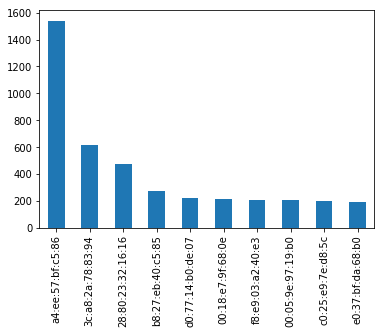

In [14]:

def convertDateTime(df):
    df['localtime'] = pd.to_datetime(df['localtime'])
    return df

df = convertDateTime(df)

fig, ax = plt.subplots()
top100 = df['ClientMacAddr'].value_counts()[:10]
top100.plot.bar(ax=ax)

In [15]:
# Generate time series data for desired mac addresses

In [16]:
from datetime import timedelta

def createInitialAddresses(df, startTime):
    endTime = startTime + timedelta(hours=1)
    timeFrame = df[(df['localtime'] >= startTime) & (df['localtime'] < endTime)]
    addrCounts = df['ClientMacAddr'].value_counts()[:20].to_dict()
    return list(addrCounts.keys())

def generateMacAddrLocationTimeSeries(df, addrList,starTime , endTime):
    timeFrame = df[(df['localtime'] >= startTime) & (df['localtime'] < endTime)]
    macAddrLocation = dict()
    for addr in addrList:
        macAddrLocation[addr] = []
    
    for time in range(0, 160, 20):
        frameStartTime = startTime + timedelta(minutes=time)
        frameEndTime = frameStartTime + timedelta(minutes=10)
        frame = df[(df['localtime'] >= frameStartTime) & (df['localtime'] < frameEndTime)]
        for addr in macAddrLocation:
            records = frame.loc[frame['ClientMacAddr'] == addr]
            if records.empty:
                macAddrLocation[addr].append(None)
            else:
                macAddrLocation[addr].append(records.iloc[0])
    return macAddrLocation
        
import datetime
# knnGroupSoloClassifier(df, addrList)

startTime = datetime.datetime(2019,8,1,3,0,0,0, datetime.timezone.utc ) 
endTime = datetime.datetime(2019,8,1,6,0,0,0, datetime.timezone.utc)
addrList = createInitialAddresses(df, startTime)
macAddrLocation = generateMacAddrLocationTimeSeries(df, addrList, startTime, endTime)
macAddrLocation

{'00:05:9e:97:19:b0': [None, None, None, None, None, None, None, None],
 '00:18:e7:9f:68:0e': [None, Building                                     TPS1
  ClientMacAddr                   00:18:e7:9f:68:0e
  Level                                     Level 2
  lat                                       -22.812
  lng                                      -43.2509
  localtime        2019-08-01 03:20:26.351000+00:00
  Name: 284, dtype: object, Building                                     TPS1
  ClientMacAddr                   00:18:e7:9f:68:0e
  Level                                     Level 2
  lat                                       -22.812
  lng                                      -43.2509
  localtime        2019-08-01 03:41:01.445000+00:00
  Name: 2180, dtype: object, Building                                     TPS1
  ClientMacAddr                   00:18:e7:9f:68:0e
  Level                                     Level 2
  lat                                       -22.812
  lng           

In [17]:
# Compute distances from neighbor to neighbor

In [37]:
def computeNeighborDistance(df, addrList,starTime , endTime):
    timeFrame = df[(df['localtime'] >= startTime) & (df['localtime'] < endTime)]
    
    distances = dict()
    for addr in addrList:
        distances[addr] = dict()
        
    for time in range(0, 160, 20):
        frameStartTime = startTime + timedelta(minutes=time)
        frameEndTime = frameStartTime + timedelta(minutes=10)
        frame = df[(df['localtime'] >= frameStartTime) & (df['localtime'] < frameEndTime)]
        for addr in addrList:
            coord_1 = (-22.81152051717558, -43.24944357396987)
            for m,record in frame.iterrows():
                distances[addr][record['ClientMacAddr']] = str(distance.vincenty(coord_1, (record['lat'],record['lng'])))

    return distances
        
    
startTime = datetime.datetime(2019,8,1,3,0,0,0, datetime.timezone.utc ) 
endTime = datetime.datetime(2019,8,1,6,0,0,0, datetime.timezone.utc)
addrList = ['3c:a8:2a:78:83:94']
distances = computeNeighborDistance(df, addrList, startTime, endTime)

distances

/home/sunkam1696/inf560/ClusterChamps/env/lib/python3.5/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  from ipykernel import kernelapp as app


{'3c:a8:2a:78:83:94': {'42:b8:59:3c:4f:37': '0.05834232473103572 km',
  '6e:82:85:cb:44:45': '0.05904336855352541 km',
  'b6:00:5b:69:8b:12': '0.08143354688055089 km',
  '0a:2b:22:93:5b:ea': '0.014260734848407916 km',
  '02:44:4d:02:b7:92': '0.10265058024999882 km',
  '32:96:25:2a:1f:f7': '0.13126207903548795 km',
  'da:a1:19:07:cc:3b': '0.10417927992112766 km',
  'de:c8:a3:89:c3:ba': '0.020055679122363872 km',
  '3c:a8:2a:78:b3:e4': '0.12915738205055424 km',
  '38:80:df:99:65:19': '0.07241995273708288 km',
  'aa:04:d5:84:6a:ba': '0.04666633769994062 km',
  'ca:a0:3b:96:21:8e': '0.0035108876355609843 km',
  'da:a1:19:67:1f:5a': '0.1038367186248865 km',
  '38:80:df:76:bc:a7': '0.06669826112133055 km',
  '0e:87:ea:af:27:9b': '0.15630880562256663 km',
  'da:a1:19:92:d9:64': '0.022453768665157768 km',
  '8a:68:1c:6d:ef:5e': '0.09999244203613991 km',
  'd8:15:ef:43:7f:60': '0.005362589730357519 km',
  '90:73:5a:a8:9d:c3': '0.08014319916489508 km',
  'f2:43:4b:7b:47:40': '0.12624725952999363

In [38]:
macAddrLocation.keys()

dict_keys(['00:18:e7:9f:68:0e', 'f8:e9:03:a2:40:e3', '28:83:35:ce:73:a1', '3c:a8:2a:78:60:14', '3c:a8:2a:78:60:13', 'd0:77:14:b0:de:07', '28:80:23:32:16:16', 'c0:25:e9:7e:d8:5c', 'f8:2d:7c:e9:a6:4e', 'b8:27:eb:40:c5:85', '00:05:9e:97:19:b0', 'e0:37:bf:da:68:b0', 'dc:35:f1:be:1c:a3', '6c:e8:5c:62:02:18', '7c:8b:b5:5c:cd:c5', '3c:a8:2a:78:60:10', '8c:f7:10:76:02:70', 'a4:ee:57:bf:c5:86', '3c:a8:2a:78:83:94', '20:32:33:78:27:81'])

In [86]:
def classify(df, addrList,starTime , endTime):
    timeFrame = df[(df['localtime'] >= startTime) & (df['localtime'] < endTime)]
    
    addrList = set(addrList)
    neighbor_distances = dict()
    for addr in addrList:
        neighbor_distances[addr] = dict()
        
    for time in range(20, 160, 20):
        frameStartTime = startTime + timedelta(minutes=time)
        frameEndTime = frameStartTime + timedelta(minutes=2)
        frame = df[(df['localtime'] >= frameStartTime) & (df['localtime'] < frameEndTime)]
        for addr in addrList:
            print("Timestamp",time)
            addrLoc = frame.loc[frame['ClientMacAddr'] == addr][:1]
            if addrLoc.empty:
                neighbor_distances[addr][time] = None
            else:
                addrLoc = frame.loc[frame['ClientMacAddr'] == addr].iloc[0]
                coord_1 = (addrLoc['lat'],addrLoc['lng'])
                neighbors = []
                visited = set()
                visited.add(addr)
                for m,record in frame.iterrows():
                    d = distance.vincenty(coord_1, (record['lat'],record['lng']))
                    if record['ClientMacAddr'] not in visited:
                        visited.add(record['ClientMacAddr'])
                        neighbors.append((d.m, record['ClientMacAddr']))
                neighbors.sort()
                neighbor_distances[addr][time] = neighbors[:10]


    return neighbor_distances
        
    
startTime = datetime.datetime(2019,8,1,3,0,0,0, datetime.timezone.utc ) 
endTime = datetime.datetime(2019,8,1,6,0,0,0, datetime.timezone.utc)
addrList = ['3c:a8:2a:78:83:94']

distances = classify(df, addrList, startTime, endTime)
distances

Timestamp 20
Timestamp 40
Timestamp 60
Timestamp 80
Timestamp 100
Timestamp 120
Timestamp 140


/home/sunkam1696/inf560/ClusterChamps/env/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.


{'3c:a8:2a:78:83:94': {20: [(0.9913093402898622, 'a4:50:46:4a:0d:19'),
   (13.83656862878135, '22:07:77:76:2e:9e'),
   (18.111806015118198, '40:88:05:99:b3:36'),
   (18.54399385815268, '3c:a8:2a:78:b3:e1'),
   (20.228037923640326, 'de:14:b8:58:fa:9d'),
   (22.010413533874377, '4e:20:ac:ce:c7:1f'),
   (29.168435970336255, '38:80:df:e3:5a:45'),
   (30.36936853829875, '3c:a8:2a:78:b4:94'),
   (31.78717787125155, '38:80:df:ee:6b:1f'),
   (34.441842567925384, '38:80:df:e7:84:38')],
  40: None,
  60: [(7.419689902984126, '02:f3:96:cf:be:a6'),
   (7.487272710740744, 'dc:bf:e9:d2:f2:12'),
   (8.53603408243253, 'dc:bf:e9:ac:cc:23'),
   (9.24806610388314, 'dc:bf:e9:84:56:76'),
   (11.013034682732174, 'dc:bf:e9:1f:3f:4c'),
   (11.436148810928199, 'dc:bf:e9:94:b4:0b'),
   (14.449455721550407, 'dc:bf:e9:aa:b3:d3'),
   (16.79326224846694, 'a0:56:f3:16:a3:11'),
   (18.435197427011406, 'dc:bf:e9:31:1a:3a'),
   (19.50697290944649, 'dc:bf:e9:36:8d:ad')],
  80: [(36.83239319911344, '58:d9:c3:20:25:93'),


In [65]:
import geopy
help(geopy.distance.vincenty)

Help on class vincenty in module geopy.distance:

class vincenty(Distance)
 |  .. deprecated:: 1.13
 |     Use :class:`.geodesic` instead.
 |     Vincenty will be removed in geopy 2.0.
 |  
 |  Calculate the geodesic distance between two points using the Vincenty's
 |  method.
 |  
 |  Set which ellipsoidal model of the earth to use by specifying an
 |  ``ellipsoid`` keyword argument. The default is 'WGS-84', which is the
 |  most globally accurate model.  If ``ellipsoid`` is a string, it is
 |  looked up in the `ELLIPSOIDS` dictionary to obtain the major and minor
 |  semiaxes and the flattening. Otherwise, it should be a tuple with those
 |  values.  See the comments above the `ELLIPSOIDS` dictionary for
 |  more information.
 |  
 |  Example::
 |  
 |      >>> from geopy.distance import vincenty
 |      >>> newport_ri = (41.49008, -71.312796)
 |      >>> cleveland_oh = (41.499498, -81.695391)
 |      >>> print(vincenty(newport_ri, cleveland_oh).miles)
 |      538.390445362
 |  
 |  